In [182]:
import pandas as pd
from sklearn.model_selection import train_test_split,GridSearchCV,StratifiedKFold
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import *
from tqdm import tqdm
from utils import LoadRumoursDataset
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
import matplotlib.pylab as plt
import uuid

In [183]:
import mlflow
mlflow.set_tracking_uri("sqlite:///mlflow.db")
#mlflow.set_experiment("spyder-experiment")
import mlflow.pytorch
mlflow.set_experiment("Gradient boosting 2024-08-17")

<Experiment: artifact_location='/workspaces/rumour-detection-pheme/mlruns/7', creation_time=1723901761095, experiment_id='7', last_update_time=1723901761095, lifecycle_stage='active', name='Gradient boosting 2024-08-17', tags={}>

In [184]:
#
file_path_replies = r"/workspaces/rumour-detection-pheme/replies_charlie_hebdo.pkl"
file_path_posts = r"/workspaces/rumour-detection-pheme/posts_charlie_hebdo.pkl"


In [185]:
time_cut =1e6
processor = LoadRumoursDataset(file_path_replies, file_path_posts, time_cut)
processor.load_data()
processor.process_data()
df_final = processor.get_final_dataframe()
df_final['id'] = [uuid.uuid4() for _ in range(len(df_final))]


In [186]:
df_not_rumours = df_final[df_final.rumour==0]

n = int((df_final.rumour.sum())*1) // df_not_rumours['replies'].nunique()  # Unique number of values in 'replies' column

# Group by 'replies' and sample 'n' rows from each group
subset_df_not_rumours= df_not_rumours.groupby('replies').apply(lambda x: x.sample(n=n, random_state=42)).reset_index(drop=True)


/tmp/ipykernel_5336/1604841334.py:6: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  subset_df_not_rumours= df_not_rumours.groupby('replies').apply(lambda x: x.sample(n=n, random_state=42)).reset_index(drop=True)


In [187]:
df_final_balanced =pd.concat([subset_df_not_rumours,df_final[df_final.rumour==1]])

In [188]:
df_final_remaining = df_final[(~df_final.id.isin(subset_df_not_rumours.id))&(df_final.rumour==0)]

In [189]:
X  = df_final_balanced.drop(columns=['rumour','id'])
X = np.hstack([X.drop(columns=['embeddings_avg']).values, np.array(pd.DataFrame(X.embeddings_avg.tolist()))])
y =df_final_balanced['rumour']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.7, random_state=42,stratify=y,shuffle=True
)

In [190]:
X_test_all  = df_final_remaining.drop(columns=['rumour','id'])
X_test_all = np.hstack([X_test_all.drop(columns=['embeddings_avg']).values, np.array(pd.DataFrame(X_test_all.embeddings_avg.tolist()))])
y_test_all =df_final_remaining['rumour']
X_test_all = np.concatenate((X_test_all, X_test), axis=0)
y_test_all = pd.concat([y_test_all, y_test], axis=0)

In [207]:
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import cross_val_score

def modelfit(alg, X_train, y_train, X_test, y_test, performCV=True, printFeatureImportance=True, cv_folds=5):
    # Fit the algorithm on the data
    alg.fit(X_train, y_train)
        
    # Predict training set:
    dtrain_predictions = alg.predict(X_train)
    dtrain_predprob = alg.predict_proba(X_train)[:,1]

    # Predict test set:
    dtest_predictions = alg.predict(X_test)
    dtest_predprob = alg.predict_proba(X_test)[:,1]
    
    # Perform cross-validation:
    if performCV:
        cv_score = cross_val_score(alg, X_train, y_train, cv=cv_folds, scoring='recall')
    
    # Print model report for Train:
    print("\nModel Report Train")
    print("AUC Score : %f" % roc_auc_score(y_train, dtrain_predprob))
    print("Accuracy : %.4g" % accuracy_score(y_train, dtrain_predictions))
    print("Precision : %.4g" % precision_score(y_train, dtrain_predictions))
    print("Recall : %f" % recall_score(y_train, dtrain_predictions))
    
    # Plot confusion matrix for Train
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    sns.heatmap(confusion_matrix(y_train, dtrain_predictions), annot=True, fmt="d", cmap="Blues")
    plt.title("Confusion Matrix - Train")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    
    # Print model report for Test:
    print("\nModel Report Test")
    print("AUC Score : %f" % roc_auc_score(y_test, dtest_predprob))
    print("Accuracy : %.4g" % accuracy_score(y_test, dtest_predictions))
    print("Precision : %.4g" % precision_score(y_test, dtest_predictions))
    print("Recall : %f" % recall_score(y_test, dtest_predictions))
    
    # Plot confusion matrix for Test
    plt.subplot(1, 2, 2)
    sns.heatmap(confusion_matrix(y_test, dtest_predictions), annot=True, fmt="d", cmap="Blues")
    plt.title("Confusion Matrix - Test")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    
    plt.tight_layout()
    plt.show()
    
    if performCV:
        print("CV Score : Mean - %.7g | Std - %.7g | Min - %.7g | Max - %.7g" % (np.mean(cv_score), np.std(cv_score), np.min(cv_score), np.max(cv_score)))

    return alg




Model Report Train
AUC Score : 1.000000
Accuracy : 1
Precision : 1
Recall : 1.000000

Model Report Test
AUC Score : 0.882102
Accuracy : 0.8126
Precision : 0.8167
Recall : 0.811502


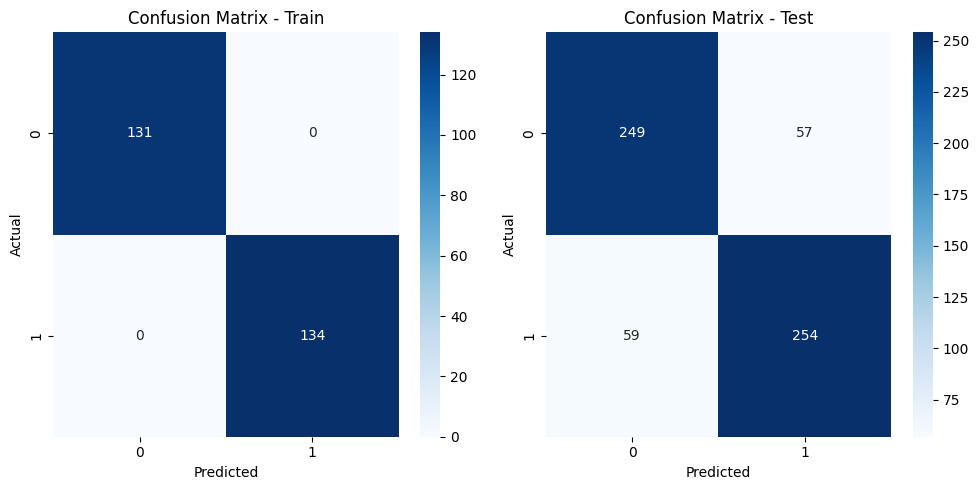

CV Score : Mean - 0.8803419 | Std - 0.04402608 | Min - 0.8461538 | Max - 0.962963


In [202]:
#Choose all predictors except target & IDcols
gbm0 = GradientBoostingClassifier(random_state=42)
modelfit(gbm0, X_train, y_train,X_test,y_test)

In [101]:
#Choose all predictors except target & IDcols
param_test1 = {'n_estimators':range(20,81,10)}
gsearch1 = GridSearchCV(estimator = GradientBoostingClassifier(learning_rate=0.1, min_samples_split=10,
                                  min_samples_leaf=10,max_depth=8,max_features='sqrt', subsample=0.8,random_state=10), 
                       param_grid = param_test1, scoring='recall',n_jobs=2, cv=5)
gsearch1.fit(X_train,y_train)

GridSearchCV(cv=5,
             estimator=GradientBoostingClassifier(max_depth=8,
                                                  max_features='sqrt',
                                                  min_samples_leaf=10,
                                                  min_samples_split=10,
                                                  random_state=10,
                                                  subsample=0.8),
             n_jobs=2, param_grid={'n_estimators': range(20, 81, 10)},
             scoring='recall')

In [102]:
gsearch1.best_params_, gsearch1.best_score_

({'n_estimators': 40}, 0.8062678062678061)

In [103]:

#Grid seach on subsample and max_features
param_test2 = {'max_depth':range(5,100,10), 'min_samples_split':range(20,1001,100)}
gsearch2 = GridSearchCV(estimator = GradientBoostingClassifier(learning_rate=0.1, n_estimators=40,
                                                max_features='sqrt', subsample=0.8, random_state=10), 
                       param_grid = param_test2, scoring='recall',n_jobs=2, cv=5)
gsearch2.fit(X_train,y_train)

GridSearchCV(cv=5,
             estimator=GradientBoostingClassifier(max_features='sqrt',
                                                  n_estimators=40,
                                                  random_state=10,
                                                  subsample=0.8),
             n_jobs=2,
             param_grid={'max_depth': range(5, 100, 10),
                         'min_samples_split': range(20, 1001, 100)},
             scoring='recall')

In [104]:
gsearch2.best_params_, gsearch2.best_score_

({'max_depth': 25, 'min_samples_split': 20}, 0.8435897435897435)

In [105]:
#Grid seach on subsample and max_features
param_test3 = { 'min_samples_split':range(20,1001,100), 'min_samples_leaf':range(20,71,10)}
gsearch3 = GridSearchCV(estimator = GradientBoostingClassifier(learning_rate=0.1, n_estimators=40,max_depth=25,
                                                    max_features='sqrt', subsample=0.8, random_state=10), 
                       param_grid = param_test3, scoring='recall',n_jobs=2, cv=5)
gsearch3.fit(X_train,y_train)

GridSearchCV(cv=5,
             estimator=GradientBoostingClassifier(max_depth=25,
                                                  max_features='sqrt',
                                                  n_estimators=40,
                                                  random_state=10,
                                                  subsample=0.8),
             n_jobs=2,
             param_grid={'min_samples_leaf': range(20, 71, 10),
                         'min_samples_split': range(20, 1001, 100)},
             scoring='recall')

In [106]:
gsearch3.best_params_, gsearch3.best_score_

({'min_samples_leaf': 30, 'min_samples_split': 120}, 0.8133903133903134)

In [107]:
#Grid seach on subsample and max_features
param_test3 = { 'min_samples_split':range(20,1001,100), 'min_samples_leaf':range(5,25,5)}
gsearch3 = GridSearchCV(estimator = GradientBoostingClassifier(learning_rate=0.1, n_estimators=40,max_depth=25,
                                                    max_features='sqrt', subsample=0.8, random_state=10), 
                       param_grid = param_test3, scoring='recall',n_jobs=2, cv=5)
gsearch3.fit(X_train,y_train)

/usr/local/python/3.10.13/lib/python3.10/site-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


GridSearchCV(cv=5,
             estimator=GradientBoostingClassifier(max_depth=25,
                                                  max_features='sqrt',
                                                  n_estimators=40,
                                                  random_state=10,
                                                  subsample=0.8),
             n_jobs=2,
             param_grid={'min_samples_leaf': range(5, 25, 5),
                         'min_samples_split': range(20, 1001, 100)},
             scoring='recall')

In [108]:
gsearch3.best_params_, gsearch3.best_score_

({'min_samples_leaf': 10, 'min_samples_split': 20}, 0.8136752136752137)

In [117]:
#Grid seach on subsample and max_features
param_test4 = {'max_features':range(4,121,5)}
gsearch4 = GridSearchCV(estimator = GradientBoostingClassifier(learning_rate=0.1, n_estimators=40,max_depth=25, 
                            min_samples_split=20, min_samples_leaf=10, subsample=0.8, random_state=10),
                       param_grid = param_test4, scoring='recall',n_jobs=2, cv=5)
gsearch4.fit(X_train,y_train)

GridSearchCV(cv=5,
             estimator=GradientBoostingClassifier(max_depth=25,
                                                  min_samples_leaf=10,
                                                  min_samples_split=20,
                                                  n_estimators=40,
                                                  random_state=10,
                                                  subsample=0.8),
             n_jobs=2, param_grid={'max_features': range(4, 121, 5)},
             scoring='recall')

In [118]:
gsearch4.best_params_, gsearch4.best_score_

({'max_features': 14}, 0.8062678062678061)

In [119]:
#Grid seach on subsample and max_features
param_test5 = {'subsample':[0.6,0.7,0.75,0.8,0.85,0.9]}
gsearch5 = GridSearchCV(estimator = GradientBoostingClassifier(learning_rate=0.1, n_estimators=40,max_depth=25, 
                            min_samples_split=20, min_samples_leaf=10, random_state=10, max_features=14),
                       param_grid = param_test5, scoring='recall',n_jobs=2, cv=5)
gsearch5.fit(X_train,y_train)

GridSearchCV(cv=5,
             estimator=GradientBoostingClassifier(max_depth=25, max_features=14,
                                                  min_samples_leaf=10,
                                                  min_samples_split=20,
                                                  n_estimators=40,
                                                  random_state=10),
             n_jobs=2,
             param_grid={'subsample': [0.6, 0.7, 0.75, 0.8, 0.85, 0.9]},
             scoring='recall')

In [120]:
gsearch5.best_params_, gsearch5.best_score_

({'subsample': 0.8}, 0.8062678062678061)


Model Report Train
AUC Score : 0.999032
Accuracy : 0.9811
Precision : 0.9778
Recall : 0.985075

Model Report Test
AUC Score : 0.899184
Accuracy : 0.8401
Precision : 0.8302
Recall : 0.859425


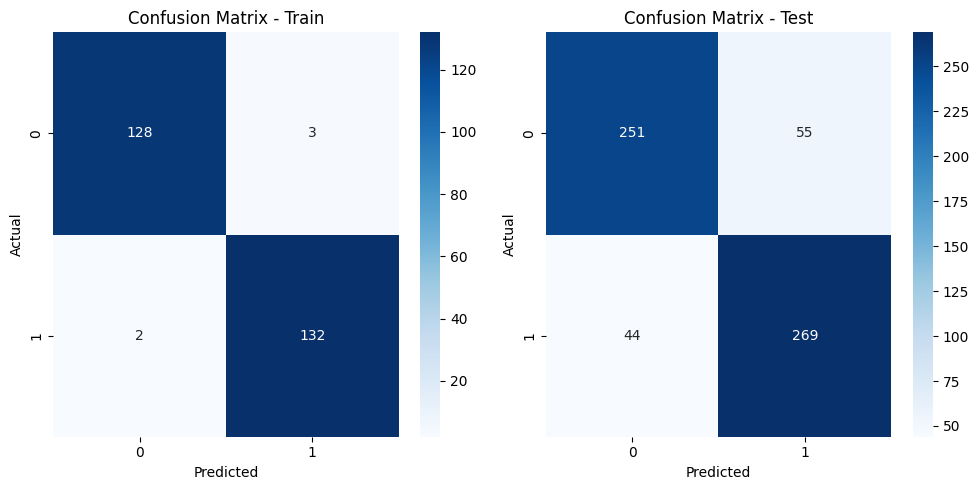

CV Score : Mean - 0.8356125 | Std - 0.05607255 | Min - 0.7407407 | Max - 0.8888889


In [203]:
#Choose all predictors except target & IDcols
gbm_tuned_1 = GradientBoostingClassifier(learning_rate=0.05, n_estimators=40,max_depth=15, min_samples_split=20, 
                                         min_samples_leaf=10, subsample=0.8, random_state=10, max_features=14)
modelfit(gbm_tuned_1,  X_train, y_train,X_test,y_test)


Model Report Train
AUC Score : 0.985986
Accuracy : 0.9208
Precision : 0.8951
Recall : 0.955224

Model Report Test
AUC Score : 0.890582
Accuracy : 0.7933
Precision : 0.4613
Recall : 0.875399


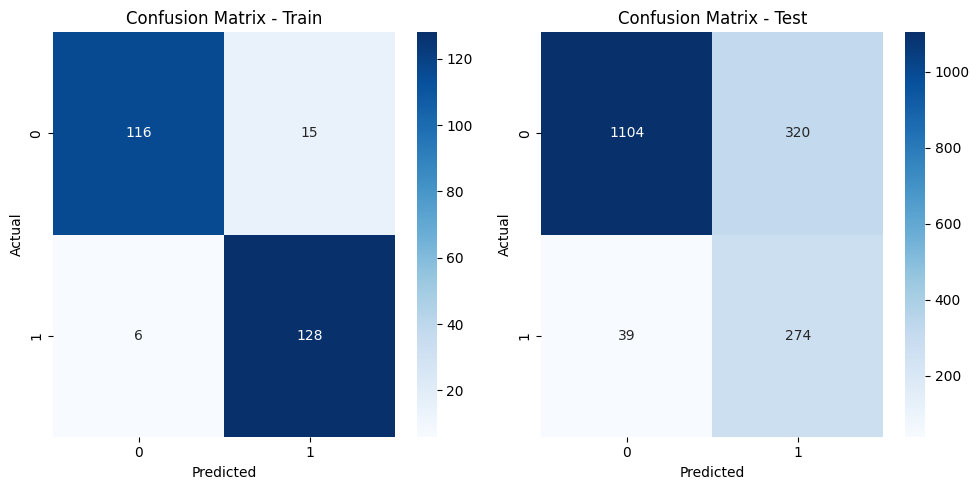

CV Score : Mean - 0.8210826 | Std - 0.04849669 | Min - 0.7407407 | Max - 0.8888889


In [208]:
#Choose all predictors except target & IDcols
gbm_tuned_1 = GradientBoostingClassifier(learning_rate=0.01, n_estimators=40,max_depth=15, min_samples_split=20, 
                                         min_samples_leaf=10, subsample=0.8, random_state=10, max_features=14)

model = modelfit(gbm_tuned_1,  X_train, y_train,X_test_all,y_test_all)

In [221]:
from sklearn.metrics import confusion_matrix


# Calculate confusion matrix
tn, fp, fn, tp = confusion_matrix(y_test_all, model.predict(X_test_all)).ravel()

# Calculate precision using the custom formula
precision = tp / (tp + fp)

print(f'Precision: {precision:.3f}')


Precision: 0.461


In [7]:
import mlflow
import mlflow.sklearn
from sklearn.metrics import recall_score, precision_score, f1_score, accuracy_score
from sklearn.model_selection import GridSearchCV

def train_optimize_model_with_mlflow(model, param_grid, cv, scoring, X_train, y_train, X_test, y_test,time_cut):
    """
    Train a Gradient Boosting Classifier with GridSearchCV and log the results with MLflow.

    Parameters:
    - model: The machine learning model (e.g., GradientBoostingClassifier()).
    - param_grid: The grid of parameters to search over.
    - cv: The cross-validation strategy (e.g., 5 for 5-fold cross-validation).
    - scoring: The scoring method for model evaluation (e.g., 'f1').
    - X_train: Training data features.
    - y_train: Training data labels.
    - X_test: Test data features.
    - y_test: Test data labels.
    """
    
    # Setup the grid search
    grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=cv, scoring=scoring, verbose=2, n_jobs=2)

    # Perform the grid search
    grid_search.fit(X_train, y_train)

    # Get the best parameters
    best_params = grid_search.best_params_
    print(f"Best parameters: {best_params}")

    # Train the best model
    best_model = grid_search.best_estimator_
    best_model.fit(X_train, y_train)

    # Predict and evaluate
    y_train_pred = best_model.predict(X_train)
    y_test_pred = best_model.predict(X_test)

        # Calculate metrics
    metrics = {
            "train_recall": recall_score(y_train, y_train_pred, average='macro'),
            "train_precision": precision_score(y_train, y_train_pred, average='macro'),
            "train_f1_score": f1_score(y_train, y_train_pred, average='macro'),
            "train_accuracy": accuracy_score(y_train, y_train_pred),
            "test_recall": recall_score(y_test, y_test_pred, average='macro'),
            "test_precision": precision_score(y_test, y_test_pred, average='macro'),
            "test_f1_score": f1_score(y_test, y_test_pred, average='macro'),
            "test_accuracy": accuracy_score(y_test, y_test_pred)
        }

    print("best params: \n",best_params)
    print("Metrics: \n",metrics)

    return best_params

    # End the MLflow run (this happens automatically when the 'with' block ends)


In [ ]:
# Define the model
gbc = GradientBoostingClassifier()

# Define the parameter grid
param_grid = {
    'n_estimators': [100, 200],
    'learning_rate': [0.001, 0.01,0.1],
    'max_depth': [3, 10,15],
    #'subsample': [0.7, 0.8],
    'min_samples_split': [2, 5]
}

cv = 5 
scoring = 'f1'

best_params =train_optimize_model_with_mlflow(gbc, param_grid, cv, scoring, X_train, y_train, X_test, y_test,time_cut)